In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Analysis on `Online Retail` dataset

## About Data

Dataset – Online Retail 

Source - https://www.kaggle.com/puneetbhaya/online-retail.

The Online Retail a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

## Problem Statement

Stores are generally spent some money on advertising or give some additional discount on certain products. But sometimes high portion of this money doesn’t make an effect because these advertising go to the customers that don’t prefer these products. 

Our goal of this project is based on the association rule mining we suggest the customes that he/she buy's item A then he/she should buy item B. And for that we build a recommendation system. So stores can recommend the best products 
for their customer that have high probability to buy these products.

In [ ]:
# import library
import numpy as np
import pandas as pd
import datetime as dt

# visualization 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
import plotnine
from plotnine import ggplot, aes

# for modelling
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# load data
path = "/content/drive/MyDrive/Sem 4 project/data/raw_online_retail.csv"
retail_df = pd.read_csv(path, encoding= 'unicode_escape')

In [ ]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [ ]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
retail_df.shape

(541909, 8)

## **Clean the Data**

In [ ]:
# missing values
round(100*(retail_df.isnull().sum())/len(retail_df), 2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [ ]:
df = retail_df.dropna()

In [ ]:
df.shape

(406829, 8)

In [ ]:
# add new column: Amount 
df['Amount'] = df['Quantity']*df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


In [ ]:
# monetary
grouped_df = df.groupby('CustomerID')['Amount'].sum()
grouped_df = grouped_df.reset_index()
grouped_df.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [ ]:
# frequency
frequency = df.groupby('CustomerID')['InvoiceNo'].count()
frequency = frequency.reset_index()
frequency.columns = ['CustomerID', 'frequency']
frequency

,CustomerID,frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17
...,...,...
4367,18280.0,10
4368,18281.0,7
4369,18282.0,13
4370,18283.0,756


In [ ]:
# merge the two dfs
grouped_df = pd.merge(grouped_df, frequency, on='CustomerID', how='inner')
grouped_df.head()

,CustomerID,Amount,frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [ ]:
# convert to datetime
df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'], 
                                          format='%d-%m-%Y %H:%M')

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


#### 1. Defining the customer base across the countries

Text(0.5, 1.0, 'UK shares the major customer base')

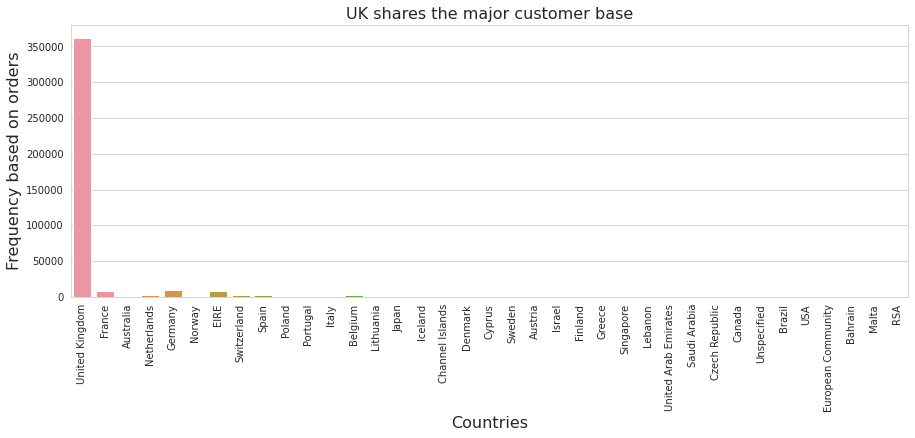

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(15,5))
sns.countplot('Country', data = df)
plt.xlabel('Countries', fontsize = 16)
plt.xticks(rotation='vertical')
plt.ylabel('Frequency based on orders', fontsize = 16)
plt.title('UK shares the major customer base', fontsize = 16)

In [ ]:
# help(ggplot)

2.Which product is most bought by the customers

In [ ]:
country_df = df.groupby(['Country']).sum()
country_df.sort_values('Amount',ascending=False,inplace=True)
country_df.drop('CustomerID',axis=1,inplace=True)
country_df.head()

,Quantity,UnitPrice,Amount
Country,,,
United Kingdom,4008533,1.178277e+06,6.767873e+06
Netherlands,200128,6.492550e+03,2.846615e+05
EIRE,136329,3.825358e+04,2.502852e+05
Germany,117448,3.766600e+04,2.216982e+05
France,109848,4.287124e+04,1.967128e+05


In [ ]:
# Average of amount paid by the customers overall countries
df['Amount'].sum() / df['Quantity'].sum()

1.6915131981818214

In [ ]:
# average of paid amount by each customer at each country ordered by number of invoices.
avg_cus = df[['Quantity','Amount','Country','InvoiceNo']].copy()

x = avg_cus.groupby(['Country','InvoiceNo']).sum()

x['Ones']=1
y = x.groupby('Country').sum()
y['AVG'] = y['Amount'] / y['Ones']
y.sort_values(['Ones','AVG'],ascending=False,inplace=True)
y.head()

,Quantity,Amount,Ones,AVG
Country,,,,
United Kingdom,4008533,6767873.394,19857,340.830609
Germany,117448,221698.210,603,367.658723
France,109848,196712.840,458,429.504017
EIRE,136329,250285.220,319,784.593166
Belgium,23152,40910.960,119,343.789580


Text(0.5, 0, 'Country')

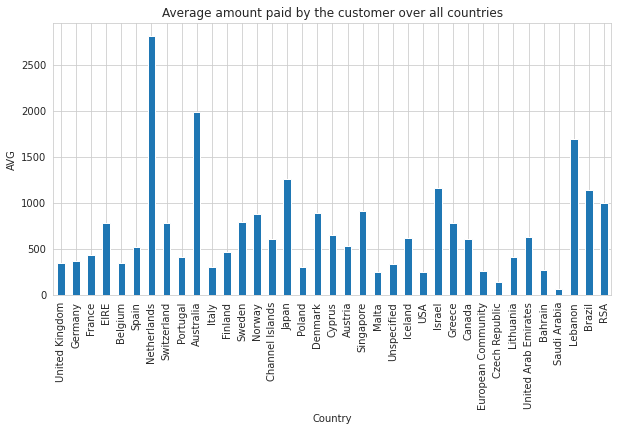

In [ ]:
y['AVG'].plot(kind='bar',figsize=(10,5),title='Average amount paid by the customer over all countries')
plt.ylabel('AVG')
plt.xlabel('Country')

We noticed that the higest average paid through customer is in Netherlands and lowest amount paid in Saudi Arabia

In [ ]:
# Which month has the highest total amount overall countries and at each country also..

modifed_df = df[['Quantity','Amount','InvoiceDate','Country']].copy()
modifed_df['Month'] = modifed_df['InvoiceDate'].dt.month 
modifed_df['Year'] = modifed_df['InvoiceDate'].dt.year 

In [ ]:
date_df = modifed_df.groupby(['Year','Month']).sum()
total_values = date_df.sort_values('Amount',ascending=False)
total_values

Quantity       Amount
Year Month                       
2011 11       669915  1132407.740
     10       569666   974603.590
     9        537496   931440.372
     5        367852   648251.080
     8        386612   616368.000
     6        356922   608013.160
     3        344012   579964.610
     7        363418   574238.481
2010 12       296362   554604.020
2011 1        269379   475074.380
     2        262833   436546.150
     4        278585   426047.851
     12       203836   342506.380

Text(0, 0.5, 'Quantity, total Amount')

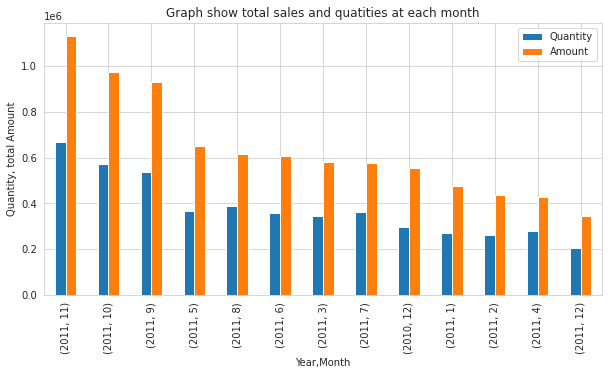

In [ ]:
total_values.plot(kind='bar',figsize=(10,5),title='Graph show total sales and quatities at each month')
plt.ylabel('Quantity, total Amount')

In [ ]:
# compute the max date
max_date = max(df['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

it shows on the date 09/12/2011 there are maximum number of customes arrive in the store

In [ ]:
# compute the diff
df['diff'] = max_date - df['InvoiceDate']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [ ]:
# recency
last_purchase = df.groupby('CustomerID')['diff'].min()
last_purchase = last_purchase.reset_index()
last_purchase.head()

,CustomerID,diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


**What is recency frequency?**

Updated Jul 5, 2019. Recency, frequency, monetary value is a marketing analysis tool used to identify a company's or an organization's best customers by using certain measures.

In [ ]:
# merge
grouped_df = pd.merge(grouped_df, last_purchase, on='CustomerID', how='inner')
grouped_df.columns = ['CustomerID', 'Amount', 'frequency', 'recency']
grouped_df.head()

,CustomerID,Amount,frequency,recency
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00


In [ ]:
# number of days only
grouped_df['recency'] = grouped_df['recency'].dt.days
grouped_df.head()

,CustomerID,Amount,frequency,recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [ ]:
help(dt)  # dt.days gives number of days

Help on module datetime:

NAME
    datetime - Fast implementation of the datetime type.

MODULE REFERENCE
    https://docs.python.org/3.7/library/datetime
    
    The following documentation is automatically generated from the Python
    source files.  It may be incomplete, incorrect or include features that
    are considered implementation detail and may vary between Python
    implementations.  When in doubt, consult the module reference at the
    location listed above.

CLASSES
    builtins.object
        date
            datetime
        time
        timedelta
        tzinfo
            timezone
    
    class date(builtins.object)
     |  date(year, month, day) --> date object
     |  
     |  Methods defined here:
     |  
     |  __add__(self, value, /)
     |      Return self+value.
     |  
     |  __eq__(self, value, /)
     |      Return self==value.
     |  
     |  __format__(...)
     |      Formats self with strftime.
     |  
     |  __ge__(self, value, /)
     |    

{'boxes': [<matplotlib.lines.Line2D at 0x7fe09e97e210>],
 'caps': [<matplotlib.lines.Line2D at 0x7fe09e978250>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe09e973290>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fe09e978d10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fe09e97e790>,
  <matplotlib.lines.Line2D at 0x7fe09e97ecd0>]}

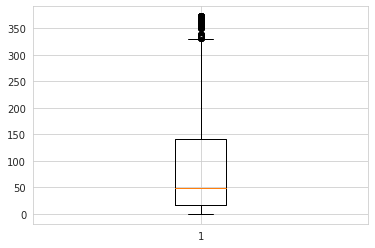

In [ ]:
# outlier treatment
plt.boxplot(grouped_df['recency'])

In [ ]:
# removing outliers from the recency data
Q1 = grouped_df.Amount.quantile(0.05)
Q3 = grouped_df.Amount.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.Amount >= Q1 - 1.5*IQR) & (grouped_df.Amount <= Q3 + 1.5*IQR)]

# outlier treatment for recency
Q1 = grouped_df.recency.quantile(0.05)
Q3 = grouped_df.recency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.recency >= Q1 - 1.5*IQR) & (grouped_df.recency <= Q3 + 1.5*IQR)]

# outlier treatment for frequency
Q1 = grouped_df.frequency.quantile(0.05)
Q3 = grouped_df.frequency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.frequency >= Q1 - 1.5*IQR) & (grouped_df.frequency <= Q3 + 1.5*IQR)]

In [ ]:
# rescaling
rfm_df = grouped_df[['Amount', 'frequency', 'recency']]

# instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4293, 3)

here, the column rfm_df_scaled is not in DataFrame object then we need to conver it into DateFrame object

In [ ]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['amount', 'frequency', 'recency']
rfm_df_scaled.head()

,amount,frequency,recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


### **Modelling**

In [ ]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
kmeans.labels_

array([2, 1, 0, ..., 2, 0, 0], dtype=int32)

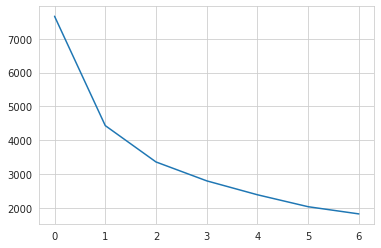

In [ ]:
# For finding number of optimum clusters

# elbow-curve/SSD
ssd = []      # sum od squared difference
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

**To understand about the K-means Cluster**
k-means Cluster: https://ukdevguy.com/k-means-algorithm-for-clustering/

In [ ]:
# assign the label
grouped_df['cluster_id'] = kmeans.labels_
grouped_df.head()

,CustomerID,Amount,frequency,recency,cluster_id
0,12346.0,0.00,2,325,4
1,12347.0,4310.00,182,1,5
2,12348.0,1797.24,31,74,3
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,4


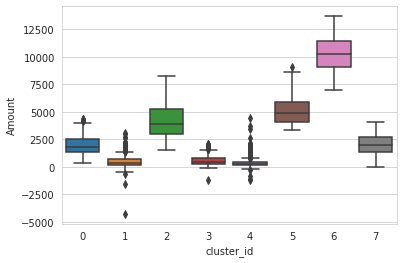

In [ ]:
# plot
sns.boxplot(x='cluster_id', y='Amount', data=grouped_df)